Filename: C:\Users\alokc\AppData\Local\Temp\7fa8bcff-0870-468d-a35d-47d116212772_frame-g-000756-2-0424.fits.bz2.772\frame-g-000756-2-0424.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


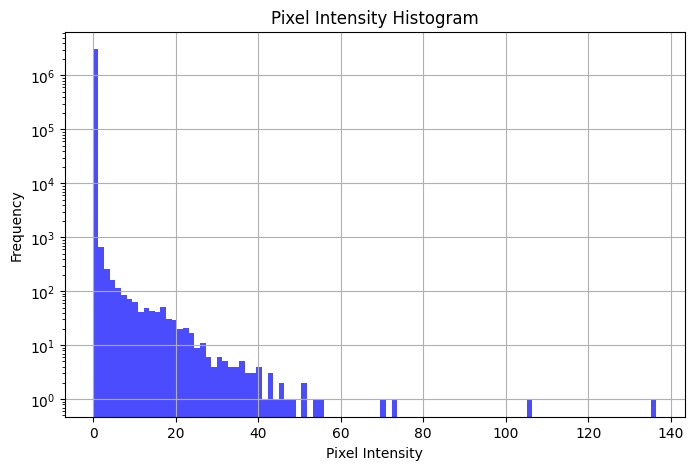

Calculated threshold: 0.8878487348556519
Loading FITS file...
Filename: C:\Users\alokc\AppData\Local\Temp\7fa8bcff-0870-468d-a35d-47d116212772_frame-g-000756-2-0424.fits.bz2.772\frame-g-000756-2-0424.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      86   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


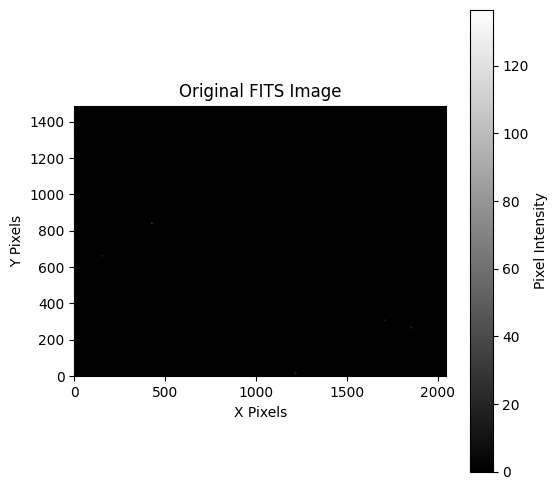

Detecting objects...
60 objects detected. Extracting features...


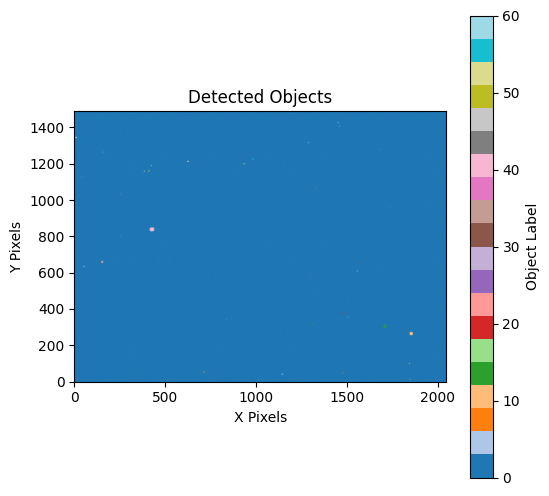

Classifying objects...


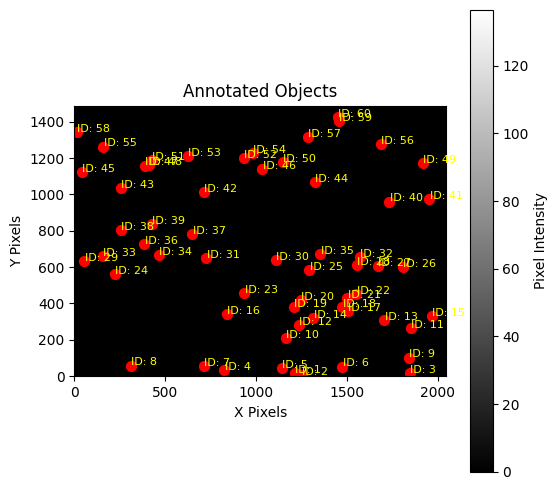

Saving results to CSV...
Results saved to output_features.csv
Pipeline completed. Results saved to output_features.csv.
    Object_ID            X            Y   Size   Luminosity    Type
0           1  1214.281726    13.761421  394.0  2658.297795    Star
1           2  1251.500000     6.500000    4.0     5.044922  Planet
2           3  1845.615385    14.615385   13.0    25.416016  Planet
3           4   824.000000    30.500000    2.0     1.908203  Planet
4           5  1142.705882    42.500000   34.0   160.184569  Planet
5           6  1474.857143    51.333333   21.0    65.015624  Planet
6           7   713.000000    53.589744   39.0   205.267582  Planet
7           8   310.125000    56.875000    8.0    10.672852  Planet
8           9  1841.047619   101.190476   21.0    60.511720  Planet
9          10  1163.500000   207.000000    2.0     1.850586  Planet
10         11  1851.306338   265.679577  284.0  2115.164005    Star
11         12  1235.384615   279.384615   13.0    21.553712  Pla

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border

# Load FITS file
def load_fits(file_path):
    try:
        with fits.open(file_path) as hdul:
            hdul.info()  # Display structure for debugging
            data = hdul[0].data
            header = hdul[0].header
        if data is None:
            raise ValueError("No data found in the FITS file.")
        return data, header
    except Exception as e:
        print(f"Error loading FITS file: {e}")
        return None, None

# Detect objects
def detect_objects(data, threshold):
    binary_image = data > threshold
    labeled_image = label(clear_border(binary_image))
    regions = regionprops(labeled_image, intensity_image=data)
    return labeled_image, regions, len(regions)

# Extract features
def extract_features(data, labeled_image, regions):
    features = []
    for idx, region in enumerate(regions, start=1):
        features.append({
            "Object_ID": idx,
            "X": region.centroid[1],
            "Y": region.centroid[0],
            "Size": region.area,
            "Luminosity": region.mean_intensity * region.area,
        })
    return features

# Classify objects
def classify_objects(features, galaxy_size_threshold=5000, star_luminosity_threshold=1000):
    for feature in features:
        if feature['Size'] > galaxy_size_threshold:
            feature['Type'] = 'Galaxy'
        elif feature['Luminosity'] > star_luminosity_threshold:
            feature['Type'] = 'Star'
        else:
            feature['Type'] = 'Planet'
    return features

# Save results to CSV
def save_to_csv(features, output_file):
    df = pd.DataFrame(features)
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Visualization functions
def plot_original_fits(data):
    plt.figure(figsize=(6, 6))
    plt.title("Original FITS Image")
    plt.imshow(data, cmap="gray", origin="lower")
    plt.colorbar(label="Pixel Intensity")
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")
    plt.show()

def plot_detected_objects(labeled_image):
    plt.figure(figsize=(6, 6))
    plt.title("Detected Objects")
    plt.imshow(labeled_image, cmap="tab20", origin="lower")
    plt.colorbar(label="Object Label")
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")
    plt.show()

def plot_annotated_objects(data, features):
    plt.figure(figsize=(6, 6))
    plt.title("Annotated Objects")
    plt.imshow(data, cmap="gray", origin="lower")
    plt.colorbar(label="Pixel Intensity")
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")

    for feature in features:
        x, y = feature["X"], feature["Y"]
        object_id = feature["Object_ID"]
        plt.scatter(x, y, color="red", marker="o", s=50)
        plt.text(x + 2, y + 2, f"ID: {object_id}", color="yellow", fontsize=8)

    plt.show()

def plot_intensity_histogram(data):
    plt.figure(figsize=(8, 5))
    plt.hist(data.ravel(), bins=100, color='blue', alpha=0.7)
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.yscale("log")  # Log scale to emphasize low-intensity values
    plt.grid(True)
    plt.show()

# Niblack's method for finding local thresholding
def calculate_threshold(data, sigma=3):
    background_mean = np.mean(data)
    background_std = np.std(data)
    threshold = background_mean + sigma * background_std
    print(f"Calculated threshold: {threshold}")
    return threshold

# Main pipeline
def process_fits_pipeline(file_path, threshold, output_file, classify=True, galaxy_size_threshold=5000, star_luminosity_threshold=1000):
    print("Loading FITS file...")
    data, header = load_fits(file_path)
    if data is None:
        print("Failed to load FITS file. Exiting pipeline.")
        return

    # Plot original FITS image
    plot_original_fits(data)

    print("Detecting objects...")
    labeled_image, regions, num_features = detect_objects(data, threshold)
    if num_features == 0:
        print("No objects detected. Adjust the threshold or check the data.")
        return

    print(f"{num_features} objects detected. Extracting features...")
    features = extract_features(data, labeled_image, regions)

    # Plot detected objects
    plot_detected_objects(labeled_image)

    if classify:
        print("Classifying objects...")
        features = classify_objects(features, galaxy_size_threshold, star_luminosity_threshold)

    # Plot annotated objects
    plot_annotated_objects(data, features)

    print("Saving results to CSV...")
    save_to_csv(features, output_file)
    print(f"Pipeline completed. Results saved to {output_file}.")
    output_data = pd.read_csv(output_file)
    print(output_data)

# Specify your FITS file path here
file_path = r"C:\Users\alokc\AppData\Local\Temp\7fa8bcff-0870-468d-a35d-47d116212772_frame-g-000756-2-0424.fits.bz2.772\frame-g-000756-2-0424.fits"
output_file = "output_features.csv"

# Load FITS data and calculate threshold
data, _ = load_fits(file_path)

# Ensure data is loaded before proceeding
if data is not None:
    plot_intensity_histogram(data)
    threshold = calculate_threshold(data, sigma=3)

    # Run the pipeline
    process_fits_pipeline(file_path, threshold, output_file)
else:
    print("Could not load data. Exiting.")
